In [1]:
import pandas as pd
import numpy as np 

%matplotlib inline
import matplotlib
import seaborn as sns
from sklearn.externals import joblib
import random

import matplotlib.pyplot as plt
from IPython.display import HTML, display

In [2]:
base_data = pd.read_csv('./data/policies.csv')

In [44]:
NUMBER_GROUP = 3
GROUPS = range(1, NB_GRP+1)

# Select all the policies exp in 201805 to 201807

In [3]:
exp_pols = base_data[(base_data.D_EXP_YRM>=201805)&(base_data.D_EXP_YRM<=201807)
                     &(base_data.LOB=='001-Private Motor')].copy()
print(exp_pols.shape[0])
exp_pols = exp_pols.loc[exp_pols.CONTRACT_TYPE.isin(
        ['Motorcycle TPFT', 'Motorcycle TPO', 'Motorcycle COMP'])==False].copy()
exp_pols = exp_pols.loc[exp_pols.CONTRACT_TYPE!= 'Private High End Cars'].copy()
print(exp_pols.shape[0])

24466
20528


In [4]:
print('Number of total policies expires in 201805 to 201807: ' + str(exp_pols.shape[0]))
print('Number of Agency for these policies: ' + str(exp_pols.SOURCE_CODE.nunique()))

Number of total policies expires in 201805 to 201807: 20528
Number of Agency for these policies: 497


# Key features 

In [5]:
# age, gender, gwp, experian grp, 
# vehicle age, vehicle CAPCTY ZMAKE (To be use: CAPCTY )
continus_features = ['clt_age',  'gwp', 'car_age', 'CAPCTY']
cate_features = ['CLTSEX', 'ZMAKE', 'PC_M_SG_17_GROUP_ALPHA_I']
key_features = continus_features + cate_features

# Check similarity bwtween 3 groups 

In [6]:
def get_cancel_rate(dataset):
    nb_renewable = dataset['PCEXP_RNABL_CANC'].sum() + dataset['PCEXP_RNABL_LAPS'].sum(
                        ) + dataset['PCEXP_RNABL_RENW'].sum() + dataset['PCEXP_RNABL_REPL'].sum()
    nb_cancel = dataset['PCEXP_RNABL_CANC'].sum()
    cancel_rate = nb_cancel*1.0/ nb_renewable
    return cancel_rate

def get_lapse_rate(dataset):
    nb_total = dataset['PCEXP_RNABL_LAPS'].sum(
                        ) + dataset['PCEXP_RNABL_RENW'].sum() + dataset['PCEXP_RNABL_REPL'].sum()
    nb_lapse = dataset['PCEXP_RNABL_LAPS'].sum()
    lapse_rate = nb_lapse*1.0/ nb_total
    return lapse_rate

#### Spilt the agency 

In [105]:
source_codes =  pd.DataFrame(exp_pols.SOURCE_CODE.value_counts(dropna=False)).reset_index(
            ).rename(columns={'index':'SOURCE_CODE', 'SOURCE_CODE':'nb_pols'})
source_codes['group_nb'] = 0

def coef_of_var(x):
    return np.std(x)/np.mean(x)

def randint_generator(nb_int, nb_grp):
    random_ints = []
    for i in range(nb_int):
        random_ints.append(random.randint(1, nb_grp))
    return random_ints

def spilt_agencies(seed = None):
    # random spilt agencies to 3 groups
    random.seed(seed)
    source_codes['group_nb'] = randint_generator(source_codes.shape[0], NUMBER_GROUP)
    grp_size = source_codes.groupby('group_nb').sum().reset_index()
#     exp_pols_wth_grp = exp_pols.merge(source_codes)

    # Get historic performace for different group
    base_2017 = base_data.loc[(base_data.LOB=='001-Private Motor')&(base_data.D_EXP_YR==2017)].copy()
    base_2017 = base_2017.merge(source_codes)
    agency_grp_stas = pd.DataFrame(columns=['agency_grp', 'nb_exp', 'cancel_rate', 'lapse_rate'])
    agency_grp_stas['agency_grp'] = GROUPS
    for grp in GROUPS:
        agency_grp_stas.loc[agency_grp_stas.agency_grp== grp, 'nb_exp'] = base_2017.loc[base_2017.group_nb==grp].shape[0]
        agency_grp_stas.loc[agency_grp_stas.agency_grp== grp, 'cancel_rate'] = get_cancel_rate(
            base_2017.loc[base_2017.group_nb==grp])
        agency_grp_stas.loc[agency_grp_stas.agency_grp== grp, 'lapse_rate'] = get_lapse_rate(
            base_2017.loc[base_2017.group_nb==grp])

    # Define a metric to quantify the similarity between the 3 groups 
    var_metric = coef_of_var(source_codes.groupby('group_nb').sum()['nb_pols'].values)*0.1 + coef_of_var(
        agency_grp_stas['cancel_rate'].values)*0.5 + coef_of_var(agency_grp_stas['lapse_rate'].values)    

    
    return source_codes, grp_size, agency_grp_stas, var_metric

In [108]:
# Search for good split based on the defined metric 
performs = []
for sd in range(100):  
    source_codes, grp_size, agency_grp_stas, var_metric = spilt_agencies(sd)
    perform_dict={}
    perform_dict['seed']=sd
    perform_dict['var_metric']=var_metric
    performs.append(perform_dict)
    
    if((sd+1)%1000==0):
        print (sd+1)
        
performs_df = pd.DataFrame(performs).sort_values('var_metric').reset_index(drop=True)
source_codes, grp_size, agency_grp_stas, var_metric = spilt_agencies(performs_df.seed.values[0])
exp_pols_wth_grp = exp_pols.merge(source_codes)
print('-------------------Seed: %d-------------------'%(sd))
print('Variance Metric: %.4f'%(var_metric))
display(grp_size)
display(agency_grp_stas)
print('\n\n')

-------------------Seed: 99-------------------
Variance Metric: 0.0543


,group_nb,nb_pols
0,1,7266
1,2,7500
2,3,5762


,agency_grp,nb_exp,cancel_rate,lapse_rate
0,1,29399,0.179827,0.353105
1,2,24610,0.177245,0.368876
2,3,32150,0.160543,0.364342


In [109]:
def compare_cate_variable(dataset, value_col, grp_col, nb_top_values, percentage=True):
    top_values = pd.DataFrame(dataset[value_col].value_counts()).reset_index()[:nb_top_values]['index'].values
    
    cate_data = dataset.groupby([value_col, grp_col]).size().reset_index().rename(columns={0:'number'})
    grp_size = cate_data.groupby(['group_nb']).sum().reset_index().rename(columns = {'number':'grp_size'})
    cate_data = cate_data.merge(grp_size)
    cate_data['percentage'] = cate_data['number']*1.0/cate_data['grp_size']
    cate_data = cate_data.loc[cate_data[value_col].isin(top_values)]
    
#     plt.figure(figsize=(16, 9))
    if (percentage == False):
        sns.barplot(x=value_col, y="number", hue=grp_col, data=cate_data)
    else:
        sns.barplot(x=value_col, y="percentage", hue=grp_col, data=cate_data)
    plt.xticks(rotation=45)

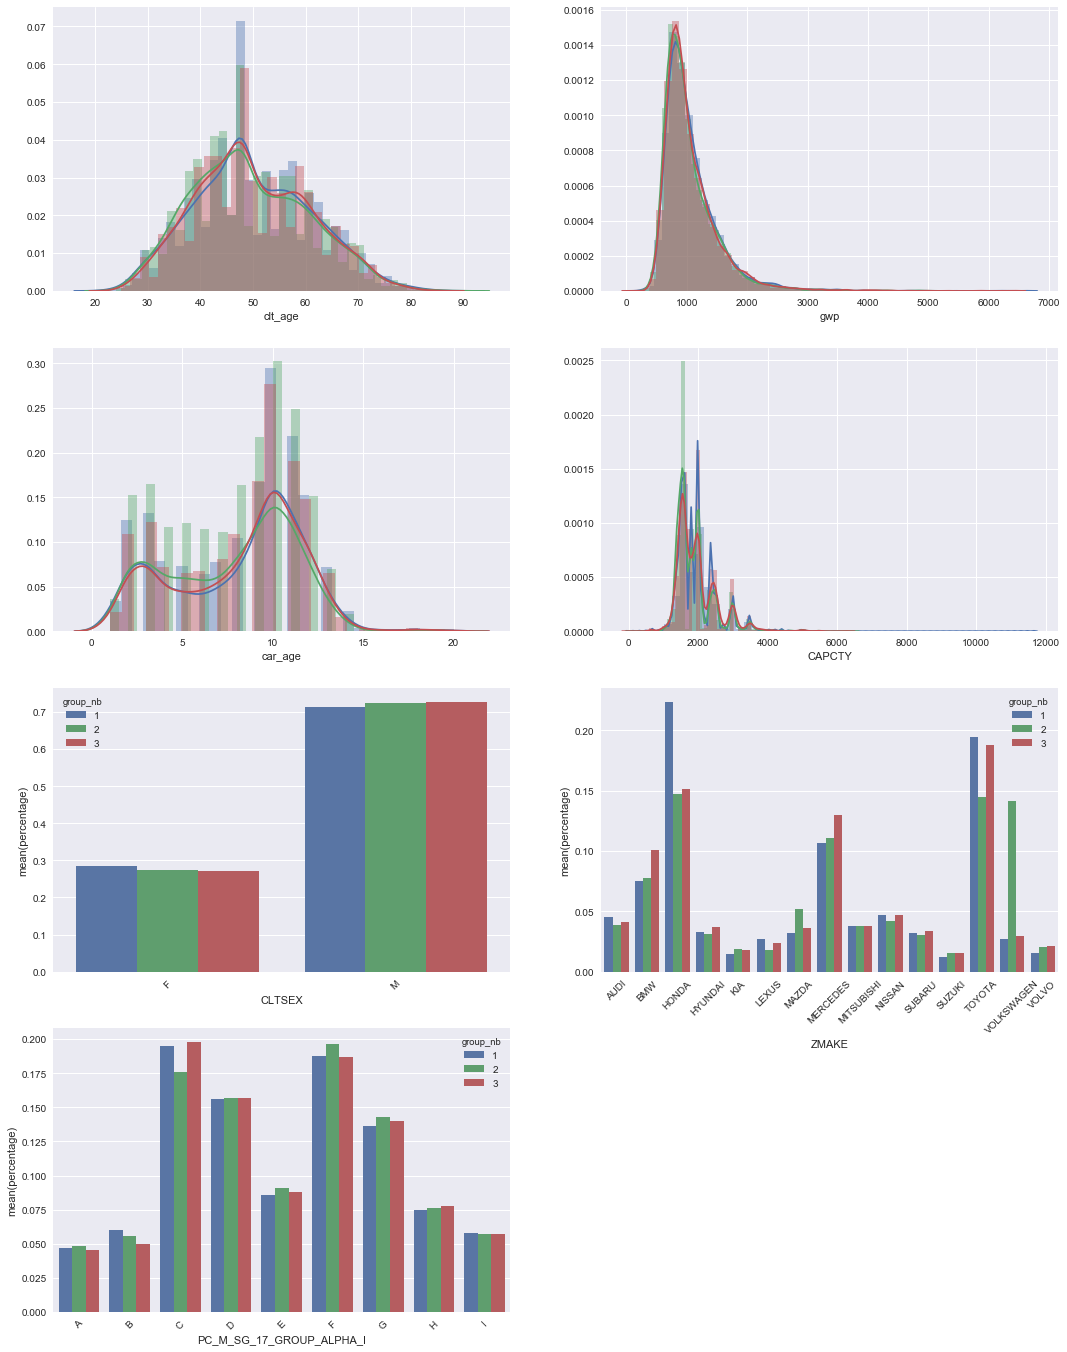

In [111]:
plt.figure(figsize=(18, (len(key_features)/2+1)*6))
i = 1
for col in key_features:
    plt.subplot(len(key_features)/2+1, 2, i)
    if(col in continus_features):
        for grp in GROUPS:
            sns.distplot(exp_pols_wth_grp.loc[exp_pols_wth_grp['group_nb']==grp][col])
    else:
        compare_cate_variable(exp_pols_wth_grp, col, 'group_nb', 15)  
    i+=1